<a href="https://www.kaggle.com/code/masatomurakawamm/transformer-application-of-masked-language-model?scriptVersionId=98197063" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

---
# [Tabular Playground Series - Jun 2022][1]

- The June edition of the 2022 Tabular Playground series is all about data imputation. The dataset has similarities to the [May 2022 Tabular Playground](https://www.kaggle.com/competitions/tabular-playground-series-may-2022/overview), except that there are no targets. Rather, there are missing data values in the dataset, and your task is to predict what these values should be.

---
#### **The aim of this notebook is to impute the missing values with Transformer model, which is trained on the task of application of Masked Language Modeling (MLM).**
- **1. Conduct exploratory data analysis (EDA).**
- **2. Converting numerical features into categorical features by binning.**
- **3. Build a TabTransformer model.**
- **4. Train the TabTransformer model on the MLM-like training task.**

---
**References:** Thanks to previous great lectures, codes and notebooks.
- [🔥🔥[TensorFlow]TabTransformer🔥🔥][2]
- [Structured data learning with TabTransformer][3]
- [Sachin's Blog Tensorflow Learning Rate Finder][4]
- [End-to-end Masked Language Modeling with BERT][7]
- [Customize what happens in Model.fit][8]
- [Fine-tuning a masked language model][9]

**My Previous Notebooks:**
- [SpaceshipTitanic: EDA + TabTransformer[TensorFlow]][5]

---
### **If you find this notebook useful, please do give me an upvote. It helps me keep up my motivation.**
#### **Also, I would appreciate it if you find any mistakes and help me correct them.**

---
[1]: https://www.kaggle.com/competitions/tabular-playground-series-jun-2022/overview
[2]: https://www.kaggle.com/code/usharengaraju/tensorflow-tabtransformer
[3]: https://colab.research.google.com/github/keras-team/keras-io/blob/master/examples/structured_data/ipynb/tabtransformer.ipynb
[4]: https://sachinruk.github.io/blog/tensorflow/learning%20rate/2021/02/15/Tensorflow-Learning-Rate-Finder.html
[5]: https://www.kaggle.com/code/masatomurakawamm/spaceshiptitanic-eda-tabtransformer-tensorflow

[7]: https://keras.io/examples/nlp/masked_language_modeling/
[8]: https://www.tensorflow.org/guide/keras/customizing_what_happens_in_fit
[9]: https://huggingface.co/course/chapter7/3?fw=tf

### **Masked Language Modeling (MLM)**

MLM is famous for a pre-training tasks of BERT model: transformer-based language model for Natural Language Processing (NLP). In MLM training, a part of input words is replaced with the `MASK` token. And the model predicts the masked inputs based on the contextual information from un-masked input words.

<img src="https://ainow.ai/wp-content/uploads/2019/04/BERT-image1.png" width="500"/>

---
In this competition, I applied MLM to missing value imputation task. 
The methods of training a Transformer-based model (TabTransformer) on MLM-like task is as follows.
1. The data which does not include any missing values is used for training data.
2. A part of input data is rondomly replaced with mask token, and the original values of masked positions are target values.
3. The model outputs each values corresponding to each input features. For the MSE loss calculation, outputs corresponding to masked inputs are considered.
4. After training, I will use the trained model as the imputer. Missing values in all data are replaced with mask token, and the model fills them based on contextualized input feature information.

<h1 style="background:#05445E; border:0; border-radius: 12px; color:#D3D3D3"><center>0. TABLE OF CONTENTS</center></h1>

<ul class="list-group" style="list-style-type:none;">
    <li><a href="#1" class="list-group-item list-group-item-action">1. Settings</a></li>
    <li><a href="#2" class="list-group-item list-group-item-action">2. Data Loading</a></li>
    <li><a href="#3" class="list-group-item list-group-item-action">3. Exploratory Data Analysis</a>
        <ul class="list-group" style="list-style-type:none;">
            <li><a href="#3.1" class="list-group-item list-group-item-action">3.1 Numerical Features</a>
                <ul class="list-group" style="list-style-type:none;">
                    <li><a href="#3.1.1" class="list-group-item list-group-item-action">3.1.1 Statistics of Numerical Features</a></li>
                    <li><a href="#3.1.2" class="list-group-item list-group-item-action">3.1.2 Binning for Numerical Features</a></li>
                </ul>
            </li>
            <li><a href="#3.2" class="list-group-item list-group-item-action">3.2 Categorical Feature</a></li>
        </ul>
    </li>
    <li><a href="#4" class="list-group-item list-group-item-action">4. Model and Dataset</a>
        <ul class="list-group" style="list-style-type:none;">
            <li><a href="#4.1" class="list-group-item list-group-item-action">4.1 Dataset for MLM-like training</a></li>
            <li><a href="#4.2" class="list-group-item list-group-item-action">4.2 Preprocessing Model</a></li>
            <li><a href="#4.3" class="list-group-item list-group-item-action">4.3 Training Model</a></li>
        </ul>
    </li>
    <li><a href="#5" class="list-group-item list-group-item-action">5. Model Training</a>
        <ul class="list-group" style="list-style-type:none;">
            <li><a href="#5.1" class="list-group-item list-group-item-action">5.1 Learning Rate Finder</a></li>
            <li><a href="#5.2" class="list-group-item list-group-item-action">5.2 Model Training</a></li>
        </ul>
    </li>
    <li><a href="#6" class="list-group-item list-group-item-action">6. Missing Value Imputation</a></li>
</ul>


<a id ="1"></a><h1 style="background:#05445E; border:0; border-radius: 12px; color:#D3D3D3"><center>1. Settings</center></h1>

In [1]:
## Import dependencies 
import numpy as np
import pandas as pd
import scipy as sp

import matplotlib.pyplot as plt 
%matplotlib inline
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

import os
import pathlib
import gc
import sys
import re
import math 
import random
import functools
import time 
import datetime as dt
from tqdm import tqdm 

import sklearn
from sklearn.model_selection import KFold, StratifiedKFold

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

import warnings
warnings.filterwarnings('ignore')

print('import done!')

import done!


In [2]:
## Parameters
data_config = {'data_csv_path': '../input/tabular-playground-series-jun-2022/data.csv',
               'sample_submission_path': '../input/tabular-playground-series-jun-2022/sample_submission.csv',
              }

exp_config = {'gpu': True,
              'tf_memory_limit': True,
              'n_bins': 64,
              'mask_ratio': 0.2,
              'mask_token': -100,
              'batch_size': 512,
              'val_size': 5_000,
              'learning_rate': 5e-3,
              'weight_decay': 0.0001,
              'train_epochs': 8,
              'checkpoint_filepath': './tmp/model/exp.ckpt',
             }

model_config = {'embedding_dim': 24,
                'num_transformer_blocks': 6,
                'num_heads': 3,
                'tf_dropout_rates': [0., 0., 0., 0., 0., 0.,],
                'ff_dropout_rates': [0., 0., 0., 0., 0., 0.,],
                'mlp_dropout_rates': [0., 0.1],
                'mlp_hidden_units_factors': [4, 4],
               }

print('Parameters setted!')

Parameters setted!


In [3]:
## For reproducible results    
def seed_all(s):
    random.seed(s)
    np.random.seed(s)
    tf.random.set_seed(s)
    os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
    os.environ['PYTHONHASHSEED'] = str(s) 
    print('Seeds setted!')
    
global_seed = 42
seed_all(global_seed)


## Limit GPU Memory in TensorFlow
## Because TensorFlow, by default, allocates the full amount of available GPU memory when it is launched. 
if exp_config['tf_memory_limit']:
    physical_devices = tf.config.list_physical_devices('GPU')
    if len(physical_devices) > 0:
        for device in physical_devices:
            tf.config.experimental.set_memory_growth(device, True)
            print('{} memory growth: {}'.format(device, tf.config.experimental.get_memory_growth(device)))
        else:
            print("Not enough GPU hardware devices available")

Seeds setted!
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU') memory growth: True
Not enough GPU hardware devices available


2022-06-13 00:15:32.824142: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-13 00:15:32.829587: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-13 00:15:32.830244: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


<a id ="2"></a><h1 style="background:#05445E; border:0; border-radius: 12px; color:#D3D3D3"><center>2. Data Loading</center></h1>

---
### [File and Data Field Descriptions](https://www.kaggle.com/competitions/tabular-playground-series-jun-2022/data)

- **data.csv** - the file includes normalized continuous data and categorical data; your task is to predict the values of the missing data.

- **sample_submission.csv** - a sample submission file in the correct format; the row-col indicator corresponds to the row and column of each missing value in data.csv

---
### [Submission & Evaluation](https://www.kaggle.com/competitions/tabular-playground-series-jun-2022/overview/evaluation)

- Submissions are scored on the root mean squared error (RMSE).

---

In [4]:
## Data Loading
data_df = pd.read_csv(data_config['data_csv_path'])
submission_df = pd.read_csv(data_config['sample_submission_path'])

print(f'train_length: {len(data_df)}')
print(f'submission_length: {len(submission_df)}')

train_length: 1000000
submission_length: 1000000


In [5]:
## Null Value Check
print('data_df.info()'); print(data_df.info(), '\n')

## train_df Check
data_df.head()

data_df.info()
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 81 columns):
 #   Column  Non-Null Count    Dtype  
---  ------  --------------    -----  
 0   row_id  1000000 non-null  int64  
 1   F_1_0   981603 non-null   float64
 2   F_1_1   981784 non-null   float64
 3   F_1_2   981992 non-null   float64
 4   F_1_3   981750 non-null   float64
 5   F_1_4   981678 non-null   float64
 6   F_1_5   981911 non-null   float64
 7   F_1_6   981867 non-null   float64
 8   F_1_7   981872 non-null   float64
 9   F_1_8   981838 non-null   float64
 10  F_1_9   981751 non-null   float64
 11  F_1_10  982039 non-null   float64
 12  F_1_11  981830 non-null   float64
 13  F_1_12  981797 non-null   float64
 14  F_1_13  981602 non-null   float64
 15  F_1_14  981961 non-null   float64
 16  F_2_0   1000000 non-null  int64  
 17  F_2_1   1000000 non-null  int64  
 18  F_2_2   1000000 non-null  int64  
 19  F_2_3   1000000 non-null  int64  
 20  F_2_4   10

,row_id,F_1_0,F_1_1,F_1_2,F_1_3,F_1_4,F_1_5,F_1_6,F_1_7,F_1_8,...,F_4_5,F_4_6,F_4_7,F_4_8,F_4_9,F_4_10,F_4_11,F_4_12,F_4_13,F_4_14
0,0,-0.354591,-0.464038,2.304115,0.734486,1.696395,0.136285,-0.518344,0.502640,-1.852504,...,3.744152,0.794438,0.265185,-0.561809,0.196480,0.373434,6.206995,3.809505,1.236486,1.182055
1,1,1.380940,-0.499626,-0.418548,1.911725,-0.826130,-1.715371,-0.577091,-1.041486,0.596067,...,-2.895826,-0.738275,2.361818,-0.060753,0.727249,-0.271882,5.232157,-4.218259,-2.724883,-0.063775
2,2,0.256023,-1.059874,NaN,0.345678,1.513814,1.243864,-0.509648,-0.800481,-0.115945,...,2.252834,0.472496,2.491386,0.353381,-0.260682,-0.000833,-0.116457,-2.131747,3.661499,-0.131576
3,3,-0.728420,-2.432399,-2.453602,-0.020509,0.333397,0.086049,-1.787601,0.667011,0.761564,...,2.004600,-4.664806,-0.847211,-0.264249,0.664334,-0.557868,8.499483,-4.738799,-3.054611,0.494152
4,4,0.590212,-0.066127,0.468009,-1.096038,0.119399,-1.809710,0.466358,-0.053196,-0.580320,...,0.976937,2.558883,3.377724,0.846891,0.696032,0.554121,-5.979714,-2.869631,3.733057,-0.722943


In [6]:
submission_df.head()

,row-col,value
0,0-F_1_14,0.0
1,0-F_3_23,0.0
2,1-F_3_24,0.0
3,2-F_1_2,0.0
4,2-F_4_2,0.0


<a id ="3"></a><h1 style="background:#05445E; border:0; border-radius: 12px; color:#D3D3D3"><center>3. Exploratory Data Analysis</center></h1>

In [7]:
## Duplicates check
features = list(data_df.columns)
features.remove('row_id')
#print(f'features: {features}')

data = data_df.duplicated(subset=features)
print(f'Number of duplicates: {data.values.sum()}')

data_df = data_df.drop_duplicates(subset=features)

Number of duplicates: 0


The max number of NaN values per sample is 9.


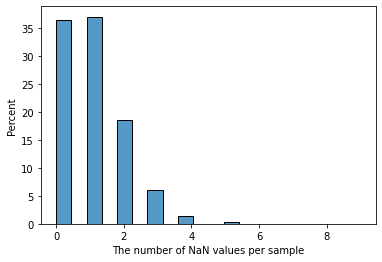

In [8]:
## Check the number of NaN values per sample.
n_null = data_df.isnull().sum(axis=1)
plot = sns.histplot(data=n_null, bins=20, stat="percent")
plot.set_xlabel('The number of NaN values per sample')
print(f'The max number of NaN values per sample is {n_null.max()}.')

In [9]:
## Heatmap of correlation matrix
fig = px.imshow(data_df.corr(),
                color_continuous_scale='RdBu_r',
                color_continuous_midpoint=0, 
                aspect='auto')
fig.update_layout(height=1000, 
                  width=1000,
                  title = "Heatmap",                  
                  showlegend=False)
fig.show()

In [10]:
numerical_features = ['F_1_0', 'F_1_1', 'F_1_2', 'F_1_3', 'F_1_4', 'F_1_5', 'F_1_6',
       'F_1_7', 'F_1_8', 'F_1_9', 'F_1_10', 'F_1_11', 'F_1_12', 'F_1_13',
       'F_1_14', 'F_3_0', 'F_3_1', 'F_3_2',
       'F_3_3', 'F_3_4', 'F_3_5', 'F_3_6', 'F_3_7', 'F_3_8', 'F_3_9', 'F_3_10',
       'F_3_11', 'F_3_12', 'F_3_13', 'F_3_14', 'F_3_15', 'F_3_16', 'F_3_17',
       'F_3_18', 'F_3_19', 'F_3_20', 'F_3_21', 'F_3_22', 'F_3_23', 'F_3_24',
       'F_4_0', 'F_4_1', 'F_4_2', 'F_4_3', 'F_4_4', 'F_4_5', 'F_4_6', 'F_4_7',
       'F_4_8', 'F_4_9', 'F_4_10', 'F_4_11', 'F_4_12', 'F_4_13', 'F_4_14',]

categorical_features = ['F_2_0', 'F_2_1', 'F_2_2', 'F_2_3', 'F_2_4', 'F_2_5', 'F_2_6',
       'F_2_7', 'F_2_8', 'F_2_9', 'F_2_10', 'F_2_11', 'F_2_12', 'F_2_13',
       'F_2_14', 'F_2_15', 'F_2_16', 'F_2_17', 'F_2_18', 'F_2_19', 'F_2_20',
       'F_2_21', 'F_2_22', 'F_2_23', 'F_2_24', ]

<a id ="3.1"></a><h2 style="background:#75E6DA; border:0; border-radius: 12px; color:black"><center>3.1 Numerical Features</center></h2>

<a id ="3.1.1"></a><h2 style="background:#D4F1F4; border:0; border-radius: 12px; color:black"><center>3.1.1 Statistics of Numerical Features </center></h2>

In [11]:
data_df[features].describe().T.style.bar(subset=['mean'],)\
                        .background_gradient(subset=['std'], cmap='coolwarm')\
                        .background_gradient(subset=['50%'], cmap='coolwarm')\
                        .background_gradient(subset=['max'], cmap='coolwarm')\

,count,mean,std,min,25%,50%,75%,max
F_1_0,981603.000000,-0.000687,1.000784,-4.664447,-0.674667,-0.000769,0.673181,5.039177
F_1_1,981784.000000,0.002091,0.999878,-4.790594,-0.672284,0.002049,0.675997,5.042807
F_1_2,981992.000000,0.000551,0.999825,-4.870645,-0.673783,0.001386,0.674490,5.130025
F_1_3,981750.000000,0.000982,0.999847,-5.053023,-0.672211,0.000370,0.674852,5.462472
F_1_4,981678.000000,0.002437,1.001151,-5.363454,-0.672326,0.002733,0.676588,4.856916
F_1_5,981911.000000,0.000635,0.999927,-5.508223,-0.673884,0.000276,0.675951,4.960724
F_1_6,981867.000000,-0.000124,1.000427,-5.199170,-0.674834,0.000814,0.673983,4.957977
F_1_7,981872.000000,-0.063857,0.725986,-6.990302,-0.500305,0.000578,0.444337,2.527570
F_1_8,981838.000000,-0.000014,1.000715,-4.566593,-0.674006,-0.000047,0.674295,4.886075
F_1_9,981751.000000,0.000451,1.000194,-4.997549,-0.673513,0.001118,0.675575,4.788579


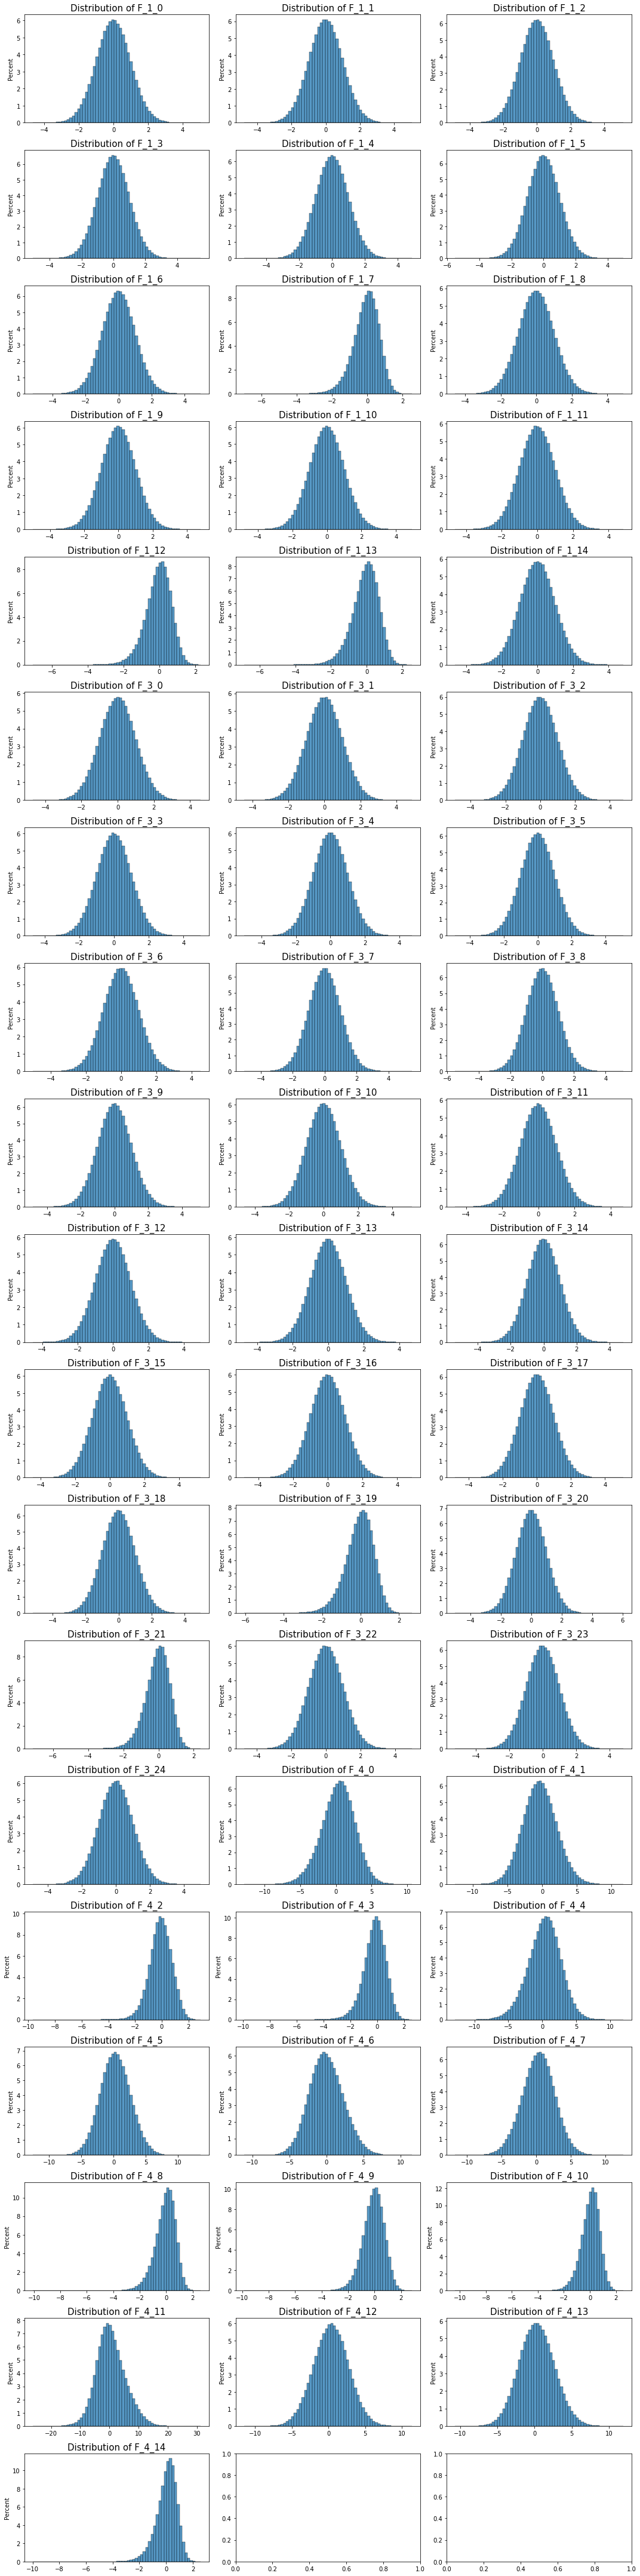

In [12]:
## Numerical feature distributions
n_cols = 3
n_rows = int(np.ceil(len(numerical_features) / n_cols))

fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(15, 60))

bins = exp_config['n_bins']
for i, column in enumerate(numerical_features):
    q, mod = divmod(i, n_cols)
    sns.histplot(x=column, data=data_df, ax=axes[q][mod], bins=bins, stat="percent", legend=True)
    axes[q][mod].set_title(f'Distribution of {numerical_features[i]}',size=15)
    axes[q][mod].set(xlabel=None)
    
#fig.suptitle('Numerical feature distributions', fontsize=20)
fig.tight_layout()
plt.show()

<a id ="3.1.2"></a><h2 style="background:#D4F1F4; border:0; border-radius: 12px; color:black"><center>3.1.2 Binning for Numerical Features </center></h2>

In [13]:
def binning_numerical(dataframe, numerical, n_bins=20):
    df = dataframe.copy()
    for nc in numerical:
        df[nc] = pd.cut(df[nc], bins=n_bins, labels=False)
    return df

n_bins = exp_config['n_bins']
data_bin_df = binning_numerical(data_df, numerical_features, n_bins=n_bins)

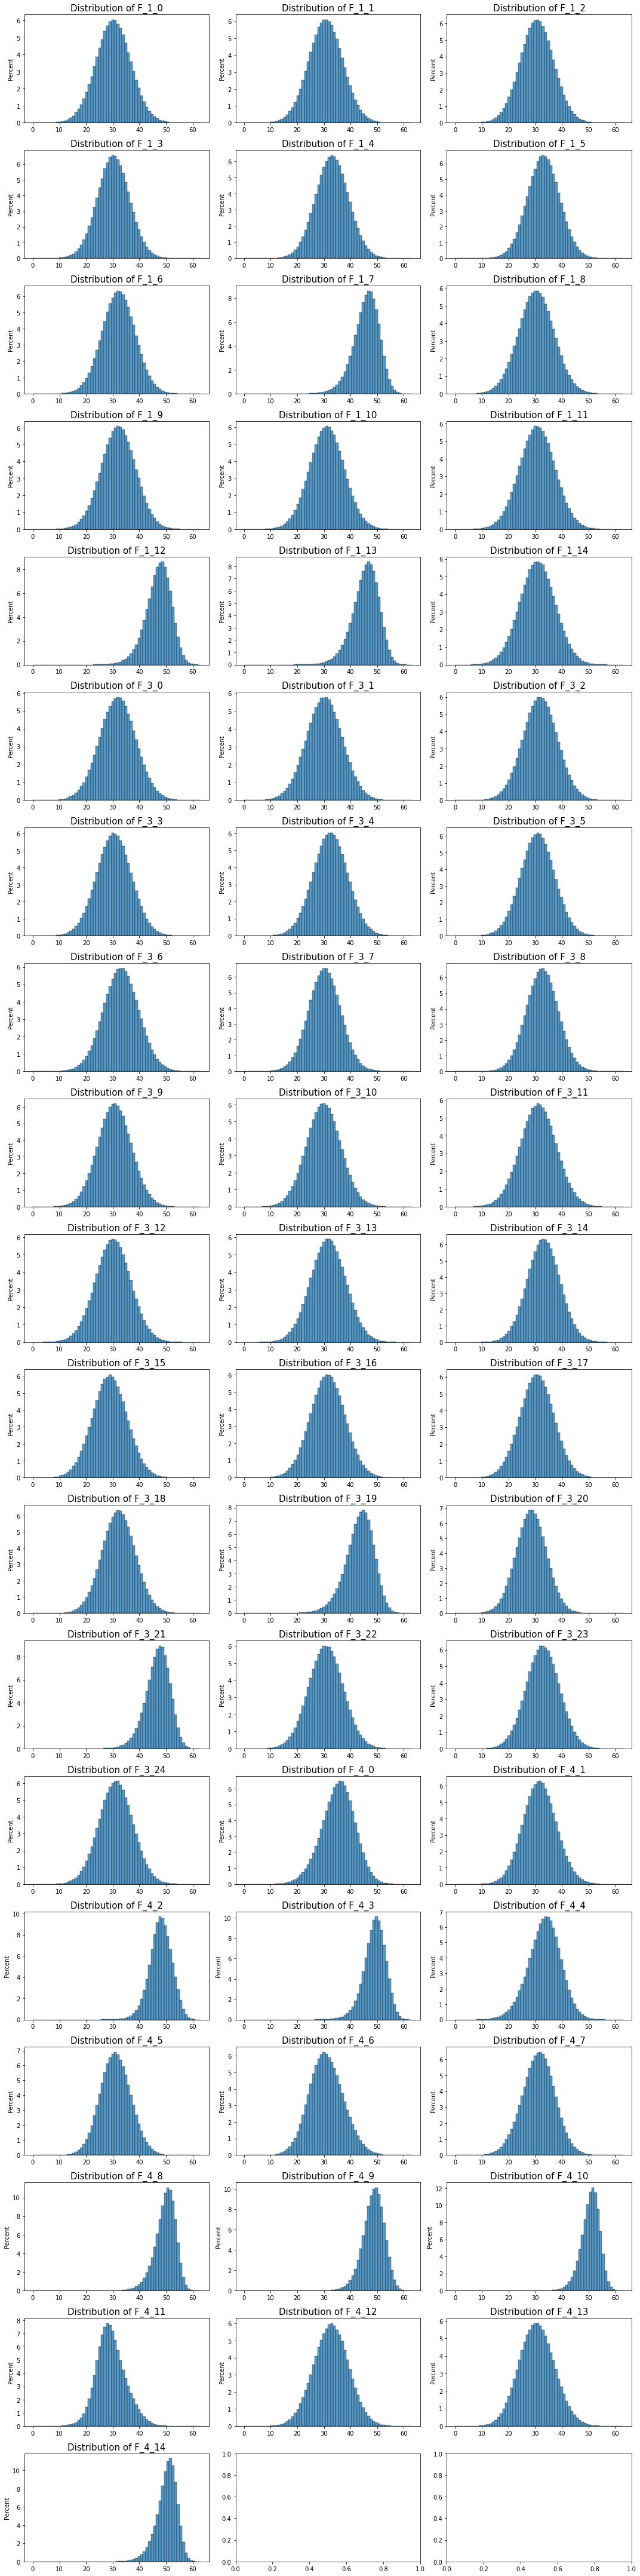

In [14]:
## Numerical feature distributions after binning
n_cols = 3
n_rows = int(np.ceil(len(numerical_features) / n_cols))

fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(15, 60))

bins = exp_config['n_bins']
for i, column in enumerate(numerical_features):
    q, mod = divmod(i, n_cols)
    sns.histplot(x=column, data=data_bin_df, ax=axes[q][mod], bins=bins, stat="percent", legend=True)
    axes[q][mod].set_title(f'Distribution of {numerical_features[i]}',size=15)
    axes[q][mod].set(xlabel=None)
    
#fig.suptitle('Numerical feature distributions after binning', fontsize=20)
fig.tight_layout()
plt.show()

<a id ="3.2"></a><h2 style="background:#75E6DA; border:0; border-radius: 12px; color:black"><center>3.2 Categorical Features</center></h2>

In [15]:
## The number of unique values in each categorical features
data_df[categorical_features].nunique()

F_2_0     16
F_2_1     15
F_2_2     11
F_2_3     15
F_2_4     17
F_2_5     13
F_2_6     13
F_2_7     17
F_2_8     14
F_2_9     12
F_2_10    18
F_2_11    14
F_2_12    16
F_2_13    16
F_2_14    14
F_2_15    14
F_2_16    14
F_2_17    13
F_2_18    15
F_2_19    14
F_2_20    15
F_2_21    16
F_2_22    16
F_2_23    12
F_2_24    18
dtype: int64

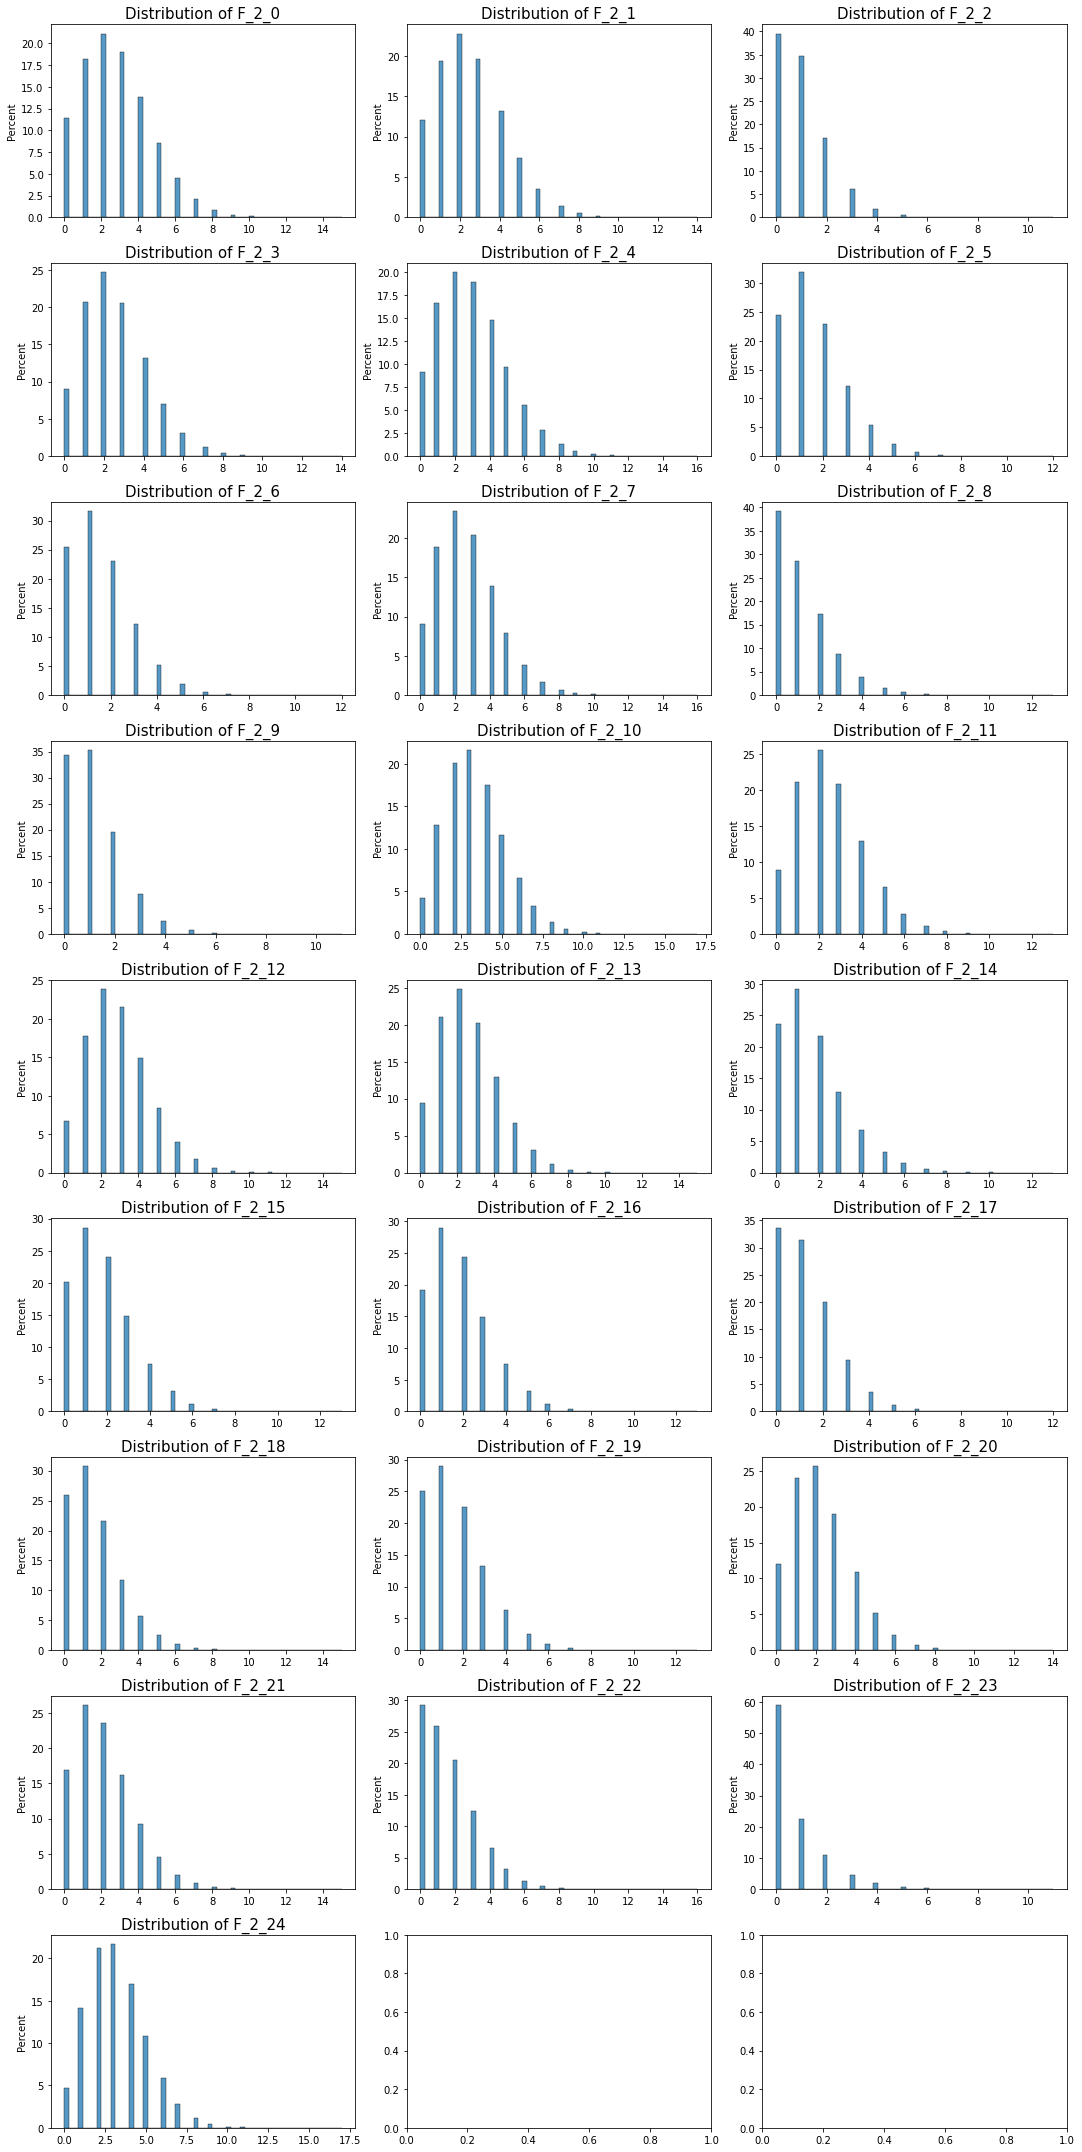

In [16]:
## Categorical feature distributions
n_cols = 3
n_rows = int(np.ceil(len(categorical_features) / n_cols))

fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(15, 30))

bins = 60
for i, column in enumerate(categorical_features):
    q, mod = divmod(i, n_cols)
    sns.histplot(x=column, data=data_bin_df, ax=axes[q][mod], bins=bins, stat="percent", legend=True)
    axes[q][mod].set_title(f'Distribution of {categorical_features[i]}',size=15)
    axes[q][mod].set(xlabel=None)
    
#fig.suptitle('Categorical feature distributions', fontsize=20)
fig.tight_layout()
plt.show()

<a id ="4"></a><h1 style="background:#05445E; border:0; border-radius: 12px; color:#D3D3D3"><center>4. Model and Dataset</center></h1>

<a id ="4.1"></a><h2 style="background:#75E6DA; border:0; border-radius: 12px; color:black"><center>4.1 Dataset for MLM-like training </center></h2>

In [17]:
## After binning, all features are categorical.
categorical_features = ['F_1_0', 'F_1_1', 'F_1_2', 'F_1_3', 'F_1_4', 'F_1_5', 'F_1_6',
       'F_1_7', 'F_1_8', 'F_1_9', 'F_1_10', 'F_1_11', 'F_1_12', 'F_1_13',
       'F_1_14', 'F_2_0', 'F_2_1', 'F_2_2', 'F_2_3', 'F_2_4', 'F_2_5', 'F_2_6',
       'F_2_7', 'F_2_8', 'F_2_9', 'F_2_10', 'F_2_11', 'F_2_12', 'F_2_13',
       'F_2_14', 'F_2_15', 'F_2_16', 'F_2_17', 'F_2_18', 'F_2_19', 'F_2_20',
       'F_2_21', 'F_2_22', 'F_2_23', 'F_2_24', 'F_3_0', 'F_3_1', 'F_3_2',
       'F_3_3', 'F_3_4', 'F_3_5', 'F_3_6', 'F_3_7', 'F_3_8', 'F_3_9', 'F_3_10',
       'F_3_11', 'F_3_12', 'F_3_13', 'F_3_14', 'F_3_15', 'F_3_16', 'F_3_17',
       'F_3_18', 'F_3_19', 'F_3_20', 'F_3_21', 'F_3_22', 'F_3_23', 'F_3_24',
       'F_4_0', 'F_4_1', 'F_4_2', 'F_4_3', 'F_4_4', 'F_4_5', 'F_4_6', 'F_4_7',
       'F_4_8', 'F_4_9', 'F_4_10', 'F_4_11', 'F_4_12', 'F_4_13', 'F_4_14']
print(len(categorical_features))

80


In [18]:
## Drop NaN-containing data
nonull_data = data_df.dropna(how='any', axis=0)
print(nonull_data.shape)

nonull_bin_data = data_bin_df.dropna(how='any', axis=0)
nonull_bin_data = nonull_bin_data.astype('int32')
print(nonull_bin_data.shape)

(364774, 81)
(364774, 81)


In [19]:
nonull_data[features].describe().T.style.bar(subset=['mean'],)\
                        .background_gradient(subset=['std'], cmap='coolwarm')\
                        .background_gradient(subset=['50%'], cmap='coolwarm')\
                        .background_gradient(subset=['max'], cmap='coolwarm')\

,count,mean,std,min,25%,50%,75%,max
F_1_0,364774.000000,-0.001055,1.001728,-4.439416,-0.676778,-0.001265,0.673087,4.484467
F_1_1,364774.000000,0.005419,1.000475,-4.292202,-0.670336,0.003727,0.679651,4.711429
F_1_2,364774.000000,-0.000921,0.999232,-4.870645,-0.675585,-0.000440,0.673635,5.130025
F_1_3,364774.000000,0.000656,0.998715,-4.826745,-0.671882,-0.000440,0.674172,5.462472
F_1_4,364774.000000,0.001707,0.999944,-4.412650,-0.672118,0.000401,0.674970,4.856916
F_1_5,364774.000000,-0.001011,1.000561,-4.746642,-0.677289,-0.002792,0.675784,4.960724
F_1_6,364774.000000,0.001692,0.999752,-4.569247,-0.671665,0.002587,0.675680,4.710044
F_1_7,364774.000000,-0.063307,0.724913,-6.990302,-0.499588,0.000457,0.443843,2.482955
F_1_8,364774.000000,-0.001342,1.000694,-4.466075,-0.675304,-0.001007,0.675009,4.886075
F_1_9,364774.000000,0.002125,1.000963,-4.324507,-0.673079,0.001708,0.677384,4.556401


In [20]:
## Train valid split (Hold-out)
val_size = exp_config['val_size']

nonull_valid_data = nonull_bin_data[:val_size]
nonull_train_data = nonull_bin_data[val_size:]

nonull_valid_target = nonull_data[:val_size]
nonull_train_target = nonull_data[val_size:]

In [21]:
def create_train_dataset(data_df,
                         target_df,
                         categorical_features,
                         mask_ratio=0.1,
                         mask_token=-100,
                         batch_size=128, 
                         shuffle=True,
                         repeat=False,
                         drop_remainder=False,
                         return_sample_weight=True):
    
    data_df = data_df.drop(['row_id'], axis=1)
    data_values = data_df.values
    
    target_df = target_df.drop(['row_id'], axis=1)
    target = target_df.values
    
    ## mask array has '1' elements by the percentage of `mask_ratio`.
    mask = np.random.random_sample(size=target.shape) 
    mask = np.where(mask < mask_ratio, 1, 0) ## Masked parts are 1s, and others are 0s. 
    
    ## Masked parts on input data are replaced with the mask_token.
    train_data = np.where(mask==1, mask_token, data_values)  
    
    train_data = train_data.astype(np.int32)
    target = target.astype(np.float32)
    
    data = {}
    for i, cf in enumerate(categorical_features):
        data[cf] = train_data[:, i]
        
    if return_sample_weight:
        sample_weight = mask.astype(np.float32) ## Only masked parts are considered in loss calculation.
        sample_weight = np.expand_dims(sample_weight, -1)
        ds = tf.data.Dataset.from_tensor_slices((data, target, sample_weight))
    else:
        ds = tf.data.Dataset.from_tensor_slices((data, target))
    
    if shuffle:
        if len(data_df) < 100000:
            buffer_size = len(data_df)
        else:
            buffer_size = 100000
        ds = ds.shuffle(buffer_size=buffer_size)
    if repeat:
        ds = ds.repeat()
    ds = ds.batch(batch_size, drop_remainder=drop_remainder)
    ds = ds.prefetch(batch_size)
    
    return ds

In [22]:
## Create datasets
mask_ratio = exp_config['mask_ratio']
batch_size = exp_config['batch_size']
mask_token = exp_config['mask_token']

train_ds = create_train_dataset(nonull_train_data, 
                                nonull_train_target,
                                categorical_features,
                                mask_ratio=mask_ratio,
                                mask_token=mask_token,
                                batch_size=batch_size,
                                shuffle=True,
                                repeat=False,
                                drop_remainder=True,
                                return_sample_weight=True)

valid_ds = create_train_dataset(nonull_valid_data,
                                nonull_valid_target,
                                categorical_features,
                                mask_ratio=mask_ratio,
                                mask_token=mask_token,
                                batch_size=batch_size,
                                shuffle=False,
                                repeat=False,
                                drop_remainder=True,
                                return_sample_weight=True)

example_data, example_labels, example_sample_weight = next(train_ds.take(1).as_numpy_iterator())

for key in example_data:
    print(f'{key}, shape:{example_data[key].shape}, {example_data[key].dtype}')
    
print(f'labels shape: {example_labels.shape}')
print(f'sample_wegihts shape: {example_sample_weight.shape}')

2022-06-13 00:17:25.976620: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-06-13 00:17:25.977296: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-13 00:17:25.978560: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-13 00:17:25.979439: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA 

F_1_0, shape:(512,), int32
F_1_1, shape:(512,), int32
F_1_2, shape:(512,), int32
F_1_3, shape:(512,), int32
F_1_4, shape:(512,), int32
F_1_5, shape:(512,), int32
F_1_6, shape:(512,), int32
F_1_7, shape:(512,), int32
F_1_8, shape:(512,), int32
F_1_9, shape:(512,), int32
F_1_10, shape:(512,), int32
F_1_11, shape:(512,), int32
F_1_12, shape:(512,), int32
F_1_13, shape:(512,), int32
F_1_14, shape:(512,), int32
F_2_0, shape:(512,), int32
F_2_1, shape:(512,), int32
F_2_2, shape:(512,), int32
F_2_3, shape:(512,), int32
F_2_4, shape:(512,), int32
F_2_5, shape:(512,), int32
F_2_6, shape:(512,), int32
F_2_7, shape:(512,), int32
F_2_8, shape:(512,), int32
F_2_9, shape:(512,), int32
F_2_10, shape:(512,), int32
F_2_11, shape:(512,), int32
F_2_12, shape:(512,), int32
F_2_13, shape:(512,), int32
F_2_14, shape:(512,), int32
F_2_15, shape:(512,), int32
F_2_16, shape:(512,), int32
F_2_17, shape:(512,), int32
F_2_18, shape:(512,), int32
F_2_19, shape:(512,), int32
F_2_20, shape:(512,), int32
F_2_21, shap

<a id ="4.2"></a><h2 style="background:#75E6DA; border:0; border-radius: 12px; color:black"><center>4.2 Preprocessing Model </center></h2>

In [23]:
def create_preprocessing_model(categorical, df, mask_token=-100):
    ## Create input layers
    preprocess_inputs = {}
    for c in categorical:
        preprocess_inputs[c] = layers.Input(shape=(1,),
                                             dtype=np.int32)
    
    ## Create preprocess layers        
    lookup_layers = {}
    for c in categorical:
        lookup_layers[c] = layers.IntegerLookup(vocabulary=df[c].unique(),
                                            mask_token=mask_token,
                                            output_mode='int')
                
    ## Create outputs
    preprocess_outputs = {}
    for c in categorical:
        preprocess_outputs[c] = lookup_layers[c](preprocess_inputs[c])
            
    ## Create model
    preprocessing_model = tf.keras.Model(preprocess_inputs,
                                         preprocess_outputs)
    
    return preprocessing_model, lookup_layers

In [24]:
## Create preprocessing model
preprocessing_model, lookup_layers = create_preprocessing_model(
    categorical_features, nonull_train_data, mask_token=mask_token)

## Apply the preprocessing model in tf.data.Dataset.map
train_ds = train_ds.map(lambda x, y, sw: (preprocessing_model(x), y, sw),
                        num_parallel_calls=tf.data.AUTOTUNE)
valid_ds = valid_ds.map(lambda x, y, sw: (preprocessing_model(x), y, sw),
                        num_parallel_calls=tf.data.AUTOTUNE)

## Display a preprocessed input sample
example_data = next(train_ds.take(1).as_numpy_iterator())[0]
for key in example_data:
    print(f'{key}, shape: {example_data[key].shape}, {example_data[key].dtype}')

2022-06-13 00:17:37.382365: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


F_1_0, shape: (512, 1), int64
F_1_1, shape: (512, 1), int64
F_1_2, shape: (512, 1), int64
F_1_3, shape: (512, 1), int64
F_1_4, shape: (512, 1), int64
F_1_5, shape: (512, 1), int64
F_1_6, shape: (512, 1), int64
F_1_7, shape: (512, 1), int64
F_1_8, shape: (512, 1), int64
F_1_9, shape: (512, 1), int64
F_1_10, shape: (512, 1), int64
F_1_11, shape: (512, 1), int64
F_1_12, shape: (512, 1), int64
F_1_13, shape: (512, 1), int64
F_1_14, shape: (512, 1), int64
F_2_0, shape: (512, 1), int64
F_2_1, shape: (512, 1), int64
F_2_2, shape: (512, 1), int64
F_2_3, shape: (512, 1), int64
F_2_4, shape: (512, 1), int64
F_2_5, shape: (512, 1), int64
F_2_6, shape: (512, 1), int64
F_2_7, shape: (512, 1), int64
F_2_8, shape: (512, 1), int64
F_2_9, shape: (512, 1), int64
F_2_10, shape: (512, 1), int64
F_2_11, shape: (512, 1), int64
F_2_12, shape: (512, 1), int64
F_2_13, shape: (512, 1), int64
F_2_14, shape: (512, 1), int64
F_2_15, shape: (512, 1), int64
F_2_16, shape: (512, 1), int64
F_2_17, shape: (512, 1), int

<a id ="4.3"></a><h2 style="background:#75E6DA; border:0; border-radius: 12px; color:black"><center>4.3 Training Model </center></h2>

### Tab Transformer

The TabTransformer architecture works as follows:

- All the categorical features are encoded as embeddings, using the same embedding_dims. This means that each value in each categorical feature will have its own embedding vector.

- A column embedding, one embedding vector for each categorical feature, is added (point-wise) to the categorical feature embedding (*Note*: We will prepare each embedding layers for each categorical features, thus, we will not use the column embeddings this time).

- The embedded categorical features are fed into a stack of Transformer blocks. Each Transformer block consists of a multi-head self-attention layer followed by a feed-forward layer.

- The outputs of the final Transformer layer, which are the contextual embeddings of the categorical features, are concatenated with the input numerical features, and fed into a final MLP block. (*Note*: This time, there are no numerical features. And I don't concatenate the contextualized features because I need each outputs corresponding to each inputs.)

<img src="https://raw.githubusercontent.com/keras-team/keras-io/master/examples/structured_data/img/tabtransformer/tabtransformer.png" width="500"/>


In [25]:
def create_training_model(categorical, lookup_layers, 
                          tf_dropout_rates, 
                          ff_dropout_rates,
                          mlp_hidden_units_factors=[2, 1],
                          mlp_dropout_rates=[0., 0.],
                          embedding_dim=12,
                          num_transformer_blocks=6, 
                          num_heads=3,):
    
    ## Create input layers
    model_inputs = {key: layers.Input(shape=(1,),
                                      dtype='int64') for key in categorical}
    
    ## Create Embeddings for categorical features
    encoded_feature_list = []
    for key in model_inputs:
        embedding = layers.Embedding(input_dim=lookup_layers[key].vocabulary_size(),
                                     output_dim=embedding_dim)
        encoded_feature = embedding(model_inputs[key])
        encoded_feature_list.append(encoded_feature)
    encoded_features = tf.concat(encoded_feature_list, axis=1)
    
    for block_idx in range(num_transformer_blocks):
        ## Create a multi-head attention layer
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads,
            key_dim=embedding_dim,
            dropout=tf_dropout_rates[block_idx],
            name=f'multi-head_attention_{block_idx}'
        )(encoded_features, encoded_features)
        ## Skip connection 1
        x = layers.Add(
            name=f'skip_connection1_{block_idx}'
        )([attention_output, encoded_features])
        ## Layer normalization 1
        x = layers.LayerNormalization(
            name=f'layer_norm1_{block_idx}', 
            epsilon=1e-6
        )(x)
        ## Feedforward
        feedforward_output = keras.Sequential([
            layers.Dense(embedding_dim, activation=keras.activations.gelu),
            layers.Dropout(ff_dropout_rates[block_idx]),
        ], name=f'feedforward_{block_idx}'
        )(x)
        ## Skip_connection 2
        x = layers.Add(
            name=f'skip_connection2_{block_idx}'
        )([feedforward_output, x])
        ## Layer normalization 2
        encoded_features = layers.LayerNormalization(
            name=f'layer_norm2_{block_idx}', 
            epsilon=1e-6
        )(x)
        
    mlp_layers = []
    mlp_hidden_units = [
        int(factor * encoded_features.shape[-1]) for factor in mlp_hidden_units_factors]
    
    for i, units in enumerate(mlp_hidden_units):
        mlp_layers.append(layers.BatchNormalization())
        mlp_layers.append(layers.Dense(units,
                                       activation=keras.activations.selu))
        mlp_layers.append(layers.Dropout(mlp_dropout_rates[i]))
    mlp_layers.append(layers.Dense(1, activation=None))
    model_outputs = keras.Sequential(mlp_layers, name='MLP')(encoded_features)
    model_outputs = tf.squeeze(model_outputs)
    
    ## Create model
    training_model = keras.Model(inputs=model_inputs,
                                 outputs=model_outputs)
    
    return training_model

In [26]:
## Settings for TabTransformer
tf_dropout_rates = model_config['tf_dropout_rates']
ff_dropout_rates = model_config['ff_dropout_rates']
embedding_dim = model_config['embedding_dim']
num_transformer_blocks = model_config['num_transformer_blocks']
num_heads = model_config['num_heads']
mlp_dropout_rates = model_config['mlp_dropout_rates']
mlp_hidden_units_factors = model_config['mlp_hidden_units_factors']

## Create TabTransformer
training_model = create_training_model(categorical_features,
                                       lookup_layers,
                                       tf_dropout_rates=tf_dropout_rates, 
                                       ff_dropout_rates=ff_dropout_rates,
                                       mlp_hidden_units_factors=mlp_hidden_units_factors,
                                       mlp_dropout_rates=mlp_dropout_rates,
                                       embedding_dim=embedding_dim,
                                       num_transformer_blocks=num_transformer_blocks,
                                       num_heads=num_heads,
                                       )

In [27]:
## model compile and build

## Settings for Training
epochs = exp_config['train_epochs']
batch_size = exp_config['batch_size']
steps_per_epoch = len(nonull_train_data)//batch_size 

## Model compile
learning_rate = exp_config['learning_rate']
weight_decay = exp_config['weight_decay']

learning_schedule = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=learning_rate,
    decay_steps=epochs*steps_per_epoch, 
    alpha=0.0)

optimizer = tfa.optimizers.AdamW(
    learning_rate=learning_schedule,
    weight_decay=weight_decay)

loss_fn = keras.losses.MeanSquaredError()

training_model.compile(optimizer=optimizer,
                       loss=loss_fn,
                       metrics=[keras.metrics.RootMeanSquaredError(),
                                keras.metrics.MeanAbsoluteError()])

training_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_81 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_82 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_83 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_84 (InputLayer)           [(None, 1)]          0                                            
____________________________________________________________________________________________

In [28]:
class MaskeImputationModel(tf.keras.Model):
    def train_step(self, inputs):
        if len(inputs) == 3:
            features, labels, sample_weight = inputs
        else:
            features, labels = inputs
            sample_weight = None
            
        with tf.GradientTape() as tape:
            predictions = self(features, training=True)
            loss = self.compiled_loss(labels, predictions, regularization_losses=self.losses,
                                      sample_weight=sample_weight) ## the loss function is configured in `compile()`
            
        ## Compute gradients
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        
        ## Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        
        ## Update metrics
        self.compiled_metrics.update_state(labels, predictions)
        
        return {m.name: m.result() for m in self.metrics}

In [29]:
## Create the training model which can receive `sample_weight` argument.
masked_imputation_inputs = training_model.input
masked_imputation_outputs = training_model(masked_imputation_inputs)

training_model = MaskeImputationModel(inputs=masked_imputation_inputs,
                                      outputs=masked_imputation_outputs)

<a id ="5"></a><h1 style="background:#05445E; border:0; border-radius: 12px; color:#D3D3D3"><center>5. Model Training</center></h1>

<a id ="5.1"></a><h2 style="background:#75E6DA; border:0; border-radius: 12px; color:black"><center>5.1 Learning Rate Finder </center></h2>

In [30]:
class LRFind(tf.keras.callbacks.Callback):
    def __init__(self, min_lr, max_lr, n_rounds):
        self.min_lr = min_lr
        self.max_lr = max_lr
        self.step_up = tf.constant((max_lr / min_lr) ** (1 / n_rounds))
        self.lrs = []
        self.losses = []
        
    def on_train_begin(self, logs=None):
        self.weights = self.model.get_weights()
        self.model.optimizer.lr = self.min_lr
        
    def on_train_batch_end(self, batch, logs=None):
        self.lrs.append(self.model.optimizer.lr.numpy())
        self.losses.append(logs['loss'])
        self.model.optimizer.lr = self.model.optimizer.lr * self.step_up
        if self.model.optimizer.lr > self.max_lr:
            self.model.stop_training = True 
    
    def on_train_end(self, logs=None):
        self.model.set_weights(self.weights)

100/100 [==============================] - 27s 109ms/step - loss: 0.7087 - root_mean_squared_error: 1.8816 - mean_absolute_error: 1.3271


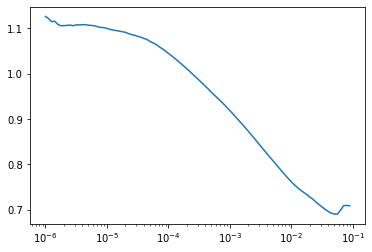

In [31]:
min_lr = 1e-6
max_lr = 1e-1
lr_find_epochs = 1
lr_find_steps = 100
lr_find_batch_size = 512

lr_find = LRFind(min_lr, max_lr, lr_find_steps)

## Model compile
learning_rate = exp_config['learning_rate']
weight_decay = exp_config['weight_decay']

learning_schedule = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=learning_rate,
    decay_steps=epochs*steps_per_epoch, 
    alpha=0.0)

optimizer = tfa.optimizers.AdamW(
    learning_rate=learning_schedule,
    weight_decay=weight_decay)

loss_fn = keras.losses.MeanSquaredError()

## LR Find
training_model.compile(optimizer=optimizer,
                       loss=loss_fn,
                       metrics=[keras.metrics.RootMeanSquaredError(),
                                keras.metrics.MeanAbsoluteError()])

training_model.fit(train_ds,
                   steps_per_epoch=lr_find_steps,
                   epochs=lr_find_epochs,
                   callbacks=[lr_find])

plt.plot(lr_find.lrs, lr_find.losses)
plt.xscale('log')
plt.show()

<a id ="5.2"></a><h2 style="background:#75E6DA; border:0; border-radius: 12px; color:black"><center>5.2 Model Training </center></h2>

In [32]:
def model_training(training_model, preprocessing_model, 
                   data_df, target_df, epochs, 
                   val_size=10000, batch_size=256):
    train_losses = []
    valid_losses = []
    for _ in range(epochs):
        ## Create train and valid datasets
        random_idx = np.random.permutation(np.arange(len(nonull_data)))
        
        valid_data = data_df.iloc[random_idx[:val_size]]
        train_data = data_df.iloc[random_idx[val_size:]]
        
        valid_target = target_df.iloc[random_idx[:val_size]]
        train_target = target_df.iloc[random_idx[val_size:]]
        
        train_ds = create_train_dataset(train_data, 
                                        train_target,
                                        categorical_features,
                                        mask_ratio=mask_ratio,
                                        mask_token=mask_token,
                                        batch_size=batch_size,
                                        shuffle=False,
                                        repeat=False,
                                        drop_remainder=False,
                                        return_sample_weight=True)
        
        train_ds = train_ds.map(lambda x, y, sw: (preprocessing_model(x), y, sw),
                                num_parallel_calls=tf.data.AUTOTUNE)
        
        valid_ds = create_train_dataset(valid_data, 
                                        valid_target,
                                        categorical_features,
                                        mask_ratio=mask_ratio,
                                        mask_token=mask_token,
                                        batch_size=batch_size,
                                        shuffle=False,
                                        repeat=False,
                                        drop_remainder=False,
                                        return_sample_weight=True)
        
        valid_ds = valid_ds.map(lambda x, y, sw: (preprocessing_model(x), y, sw),
                                num_parallel_calls=tf.data.AUTOTUNE)
        
        ## Model training
        history = training_model.fit(train_ds,
                                     epochs=1,
                                     shuffle=False,
                                     validation_data=valid_ds,
                                    )
        
        train_losses.append(history.history['loss'])
        valid_losses.append(history.history['val_loss'])
        
        gc.collect()
        
    return train_losses, valid_losses

703/703 [==============================] - 81s 116ms/step - loss: 0.0673 - root_mean_squared_error: 0.5801 - mean_absolute_error: 0.2406 - val_loss: 0.0681 - val_root_mean_squared_error: 0.5840 - val_mean_absolute_error: 0.2715


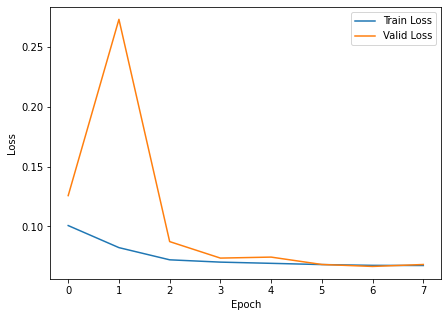

In [33]:
## Settings for Training
epochs = exp_config['train_epochs']
val_size = exp_config['val_size']
batch_size = exp_config['batch_size']
steps_per_epoch = len(nonull_train_data)//batch_size 

## Re-construct the model
training_model_config = training_model.get_config()
training_model = tf.keras.Model.from_config(training_model_config)

## Model compile
learning_rate = exp_config['learning_rate']
weight_decay = exp_config['weight_decay']

learning_schedule = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=learning_rate,
    decay_steps=epochs*steps_per_epoch, 
    alpha=0.0)

optimizer = tfa.optimizers.AdamW(
    learning_rate=learning_schedule,
    weight_decay=weight_decay)

loss_fn = keras.losses.MeanSquaredError()

training_model.compile(optimizer=optimizer,
                       loss=loss_fn,
                       metrics=[keras.metrics.RootMeanSquaredError(),
                                keras.metrics.MeanAbsoluteError()])

## Model training
train_losses, valid_losses = model_training(training_model, 
                                            preprocessing_model, 
                                            data_df=nonull_bin_data,
                                            target_df=nonull_data,
                                            epochs=epochs, 
                                            val_size=val_size,
                                            batch_size=batch_size)

## Plot the train and valid losses
plt.figure(figsize=(7, 5))
plt.plot(np.arange(epochs), train_losses, label='Train Loss')
plt.plot(np.arange(epochs), valid_losses, label='Valid Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

<a id ="6"></a><h1 style="background:#05445E; border:0; border-radius: 12px; color:#D3D3D3"><center>6. Missing Value Imputation</center></h1>

In [34]:
## Inference_model = preprocessing_model + training_model
impute_inputs = preprocessing_model.input
impute_outputs = training_model(preprocessing_model(impute_inputs))
impute_model = tf.keras.Model(inputs=impute_inputs,
                              outputs=impute_outputs)

In [35]:
def create_test_dataset(df,
                        categorical_features,
                        mask_token=-100,
                        batch_size=256, 
                        drop_remainder=False):
    
    df = df.drop(['row_id'], axis=1)
    df = df.fillna(mask_token)
    df = df.astype(np.int32)
    
    train_data = df.values
    
    data = {}
    for i, cf in enumerate(categorical_features):
        data[cf] = train_data[:, i]
    
    ds = tf.data.Dataset.from_tensor_slices(data)
    ds = ds.batch(batch_size, drop_remainder=drop_remainder)
    ds = ds.prefetch(batch_size)
    
    return ds

In [36]:
## Test Dataset
test_ds = create_test_dataset(data_bin_df,
                              categorical_features,
                              batch_size=batch_size,
                              drop_remainder=False)

In [37]:
## Inference and submission
preds = impute_model.predict(test_ds)

def imputation_extract(row_col, categorical, preds):
    row = int(row_col.split('-')[0])
    col = categorical_features.index(row_col.split('-')[1])
    return preds[row, col]

imputation_extract = functools.partial(imputation_extract,
                                       categorical=categorical_features,
                                       preds=preds)
    
submission_df['value'] = submission_df['row-col'].map(imputation_extract)
submission_df.to_csv('submission.csv', index=False)
submission_df.head()

,row-col,value
0,0-F_1_14,-0.063479
1,0-F_3_23,-0.070793
2,1-F_3_24,-0.090057
3,2-F_1_2,-0.098078
4,2-F_4_2,0.190278


---
**I think this MLM-lile imputation pre-training task could also be useful for other tabular regression or classification problems.**

---